In [1]:
import os
os.chdir('..')  # Mueve el directorio de trabajo un nivel arriba    ]


#

In [8]:
from scipy.signal.windows import gaussian
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
import scipy.signal.windows as win
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.misc import derivative
from functions_master import *
import warnings

# Suprimir FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
from scipy.signal import gaussian


In [10]:
path_air1 = r'C:\Users\esteb\Escritorio\physics\mestrado_thz_physics\paper_window\Air+Water'
archivos = os.listdir(path_air1)

labels = [extraer_humedad(nombre_archivo) for nombre_archivo in archivos]
# Filtrar solo archivos (excluyendo carpetas)
archivos = [os.path.join(path_air1, archivo) for archivo in archivos if os.path.isfile(os.path.join(path_air1, archivo))]

In [11]:
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

In [34]:
def shift_time_to_peak(t, y):
    i_max = np.argmax(np.abs(y))
    return t - t[i_max]

def extract_data_freq(path, nu1, nu2, sigma):
    df = pd.read_csv(path, delim_whitespace=True)
    y = df['X'].values
    NN = len(y)

    gauss = gaussian(NN, sigma)
    max_idx = np.argmax(np.abs(y))
    y_windowed = y 

    N = 2**12
    k = 15
    nu = sp.fft.fftfreq(N, 1 / 30)[1:N//k]
    fourier = np.abs(np.fft.fft(y_windowed, N))[1:N//k]

    mask = (nu >= nu1) & (nu <= nu2)
    return nu[mask], fourier[mask]

# === Función principal ===
conversion_factor = 33.356
def anim2(τs, τc, τp, a, sigma):
    x1, x2 = 0.15, 1.1
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), dpi=200)
    colores = ["#1f77b4", "#ff7f0e", "#2ca02c"]
    y_vent = []

    # --- Parte temporal ---
    for idx, j in enumerate(range(0, len(archivos), 20)):
        t, y = extrac_data_time(os.path.join(path_air1, archivos[j]))
        print(y)
        # y_windowed = apply_gaussian_window(y, sigma)
        # y_vent.append([t, y_windowed])
        t_shifted = shift_time_to_peak(t, y)
        axs[0].plot(t_shifted, y / max(y), color=colores[idx], label=f'{labels[j]} %')

    # --- Simulación ETHz ---
    τs_ps, τc_ps, τp_ps = τs * 1e-2, τc * 1e-2, τp * 1e-3
    t_dis = (t - t[np.argmax(y)]) * 0.1
    ethz = E_THz(t_dis, τs_ps, τc_ps, τp_ps) * np.cos(t * a)
    t_shifted_ethz = shift_time_to_peak(t, ethz.values)
    axs[0].plot(t_shifted_ethz, ethz.values / max(ethz.values), 'r', label='Vacuum (simulated)')

    axs[0].set_xlim(min(t_shifted_ethz), 20)
    axs[0].set_title('(a)')
    axs[0].set_ylabel('Electric field (arb. units)')
    axs[0].legend(loc='upper right')

    # --- Parte frecuencial ---
    N = 2**12
    k = 15
    nu = sp.fft.fftfreq(N, 1 / 30)[1:N//k]
    ethz_fft = FourierT(ethz.values, N)[1:N//k]
    mask = (nu >= x1) & (nu <= x2)
    axs[1].plot(nu[mask]*conversion_factor, np.abs(ethz_fft[mask]) / np.max(np.abs(ethz_fft[mask])), 'r')

    # Espectros experimentales
    for idx, j in enumerate(range(0, len(archivos), 20)):
        nu_f, fft_f = extract_data_freq(os.path.join(path_air1, archivos[j]), x1, x2, sigma)
        axs[1].plot(nu_f*conversion_factor, fft_f / max(fft_f), color=colores[idx], label=f'{labels[j]} %')
        if j == 0:
            regiones = [(15, 20), (23, 28), (30, 35)]
            for xmin, xmax in regiones:
                mask_region = (nu_f * conversion_factor >= xmin) & (nu_f * conversion_factor <= xmax)
                if np.any(mask_region):
                    nu_region = nu_f[mask_region] * conversion_factor
                    fft_region = fft_f[mask_region]
                    min_idx = np.argmin(fft_region)
                    axs[1].axvline(nu_region[min_idx], color='k', linestyle='--')
                    axs[1].annotate(f"{nu_region[min_idx]:.1f}", 
                                    (nu_region[min_idx]-1, fft_region[min_idx]/max(fft_f)+0.1), 
                                    textcoords="offset points", xytext=(0, -10),
                                    ha='center', fontsize=10)


    axs[1].set_title('(b)')
    axs[1].set_xlabel('k (1/cm)')
    axs[1].set_ylabel(r'Absolute Value Spectrum (arb. units)')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# === Widget interactivo ===

opc = dict(continuous_update=False, readout_format=".3f")
interact(anim2,
         τs=FloatSlider(min=0, max=5, value=5, step=0.001, **opc),
         τc=FloatSlider(min=0, max=14, value=1.380, step=0.01, **opc),
         τp=FloatSlider(min=0, max=500, value=56, step=1, **opc),
         a=FloatSlider(min=0, max=5, value=1.7, step=0.01, **opc),
         sigma=FloatSlider(min=0, max=400, value=50, step=0.01, **opc)
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='τs', max=5.0, readout_forma…

<function __main__.anim2(τs, τc, τp, a, sigma)>

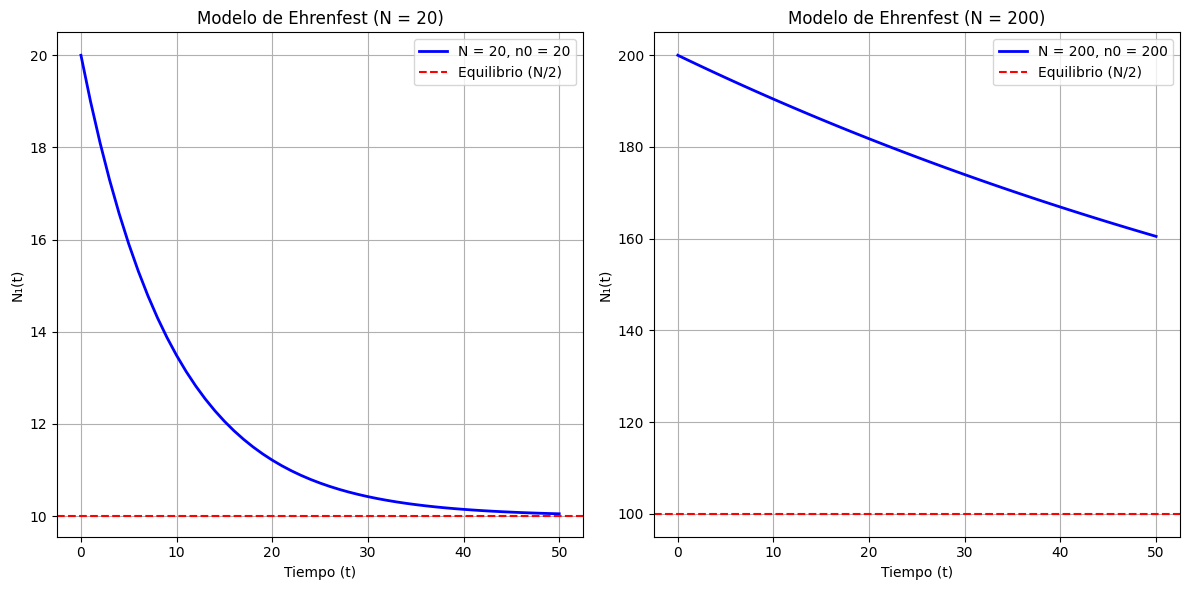

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
N_values = [20, 200]  # Los dos valores de N a graficar
n0_values = [20, 200]  # Condiciones iniciales (n0 = N)
t_max = 50            # Tiempo máximo de simulación
t = np.arange(0, t_max + 1)  # Vector de tiempo

# Crear figura
plt.figure(figsize=(12, 6))

for i, N in enumerate(N_values):
    n0 = n0_values[i]
    
    # Calcular la solución analítica
    solution = (N/2) + (1 - 2/N)**t * (n0 - N/2)
    
    # Graficar
    plt.subplot(1, 2, i+1)
    plt.plot(t, solution, 'b-', linewidth=2, label=f'N = {N}, n0 = {n0}')
    plt.axhline(y=N/2, color='r', linestyle='--', label='Equilibrio (N/2)')
    
    plt.title(f'Modelo de Ehrenfest (N = {N})')
    plt.xlabel('Tiempo (t)')
    plt.ylabel('N₁(t)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()